In [238]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

class KRR(BaseEstimator, RegressorMixin):

    def __init__(self, kernel_func , sigma=None, lamb=None, kpca_ncmps=None):

        """
        User must provide a kernelfunction, 
        sigma and lambda are optinal for initialization
        """

        self.kernel_func  = kernel_func        # kernelfunction, no default
        self.sigma        = sigma or 1.0       # sigma value, 1 default
        self.lamb         = lamb  or 1e-7      # lambda value, 1e-7 default
        self.kpca_ncmps   = kpca_ncmps or 2    # number of components for kpca, 2 default
        
        
        """
        get_params and set_params are used by sklearn e.g. for hyperparameter
        optimization
        """

    def get_params(self, deep=True):

        return {"sigma": self.sigma, "lamb": self.lamb, "kernel_func":self.kernel_func}

    def set_params(self, **parameters):

        self.sigma        = parameters["sigma"]
        self.lamb         = parameters["lamb"]      
        self.kernel_func  = parameters["kernel_func"]
        
        return self

        """
        Obtain the regression coefficients alpha and
        save the training representations because they are 
        needed for predictions
        """
    
    def fit(self, X, y):

        Kernel_train  = self.kernel_func(X,X, self.sigma)
    

        for i in range(Kernel_train.shape[0]):
            Kernel_train[i, i] += self.lamb
   
        self.ALPHA_SOL = np.linalg.solve(Kernel_train, y)
        self.XTRAIN    = X
        
        return self
    
        """
        Make the predictions for query representations Xry
        """

    def predict(self, Xqry):

        Kernel_test     = self.kernel_func(self.XTRAIN, Xqry, self.sigma)
        pred            = np.dot(self.ALPHA_SOL, Kernel_test)
        
        return pred
    
        """
        Make a kernel-pca, by first going to kernel space and 
        performing a pca afterwards, by default 
        returns the first two components
        """

    def kpca(self, X):
        Kernel_train  = self.kernel_func(X,X, self.sigma)

        from sklearn.decomposition import PCA

        pca     = PCA(n_components=self.kpca_ncmps)
        kpca    = pca.fit_transform(Kernel_train)

        return kpca

**1 d funktion  Example**

In [255]:
import numpy as np
import numpy.linalg as LA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def simple_distance(xa, xb):
    if len(xa.shape) == 1:
        measure = abs
    else:
        measure = LA.norm


    d = np.zeros((len(xa),len(xb) ))
    for i,x1 in enumerate(xa):
        for j,x2 in enumerate(xb):
            d[i][j]  = measure(x1 - x2) 

    return d    

def kernel_1d_fct_laplace(Xa, Xb, sigma):

    dist = simple_distance(Xa, Xb)
    
    return np.exp(-sigma* dist)


def kernel_1d_fct_gauss(Xa, Xb, sigma):

    dist = simple_distance(Xa, Xb)
    
    return np.exp(-sigma* dist**2)    
    

X = np.linspace(1, 7, 50)
# make a function that is complicated to fit
y = -5 *np.exp(-X)*np.sin(-X)*np.cos(X**2)   +  np.random.normal(0,1e-6,50) #* np.exp(X**2+1) #*np.arctan(np.pi*X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=True, random_state=666)
regressor = KRR(kernel_1d_fct, 1, 1e-8)

param_grid = [{"krr__sigma": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3,5e-3, 1e-2, 1e-1, 1,1e1,2e1, 1e2, 1e3, 1e4], "krr__lamb":[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-8, 1e-9], "krr__kernel_func": [kernel_1d_fct_laplace,kernel_1d_fct_gauss ]}]


pipe = Pipeline([ ('krr', regressor) ])
grid_search = 0
grid_search = GridSearchCV(pipe, param_grid, cv = 3, return_train_score=True, verbose=10, n_jobs=-1 )
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
regressor = best_model['krr']
print(regressor)
print(regressor.sigma)
print(regressor.lamb)
y_pred = best_model.predict(X_test)

Fitting 3 folds for each of 272 candidates, totalling 816 fits
KRR(kernel_func=<function kernel_1d_fct_gauss at 0x7f682a5edd90>, lamb=1e-09,
    sigma=10.0)
10.0
1e-09


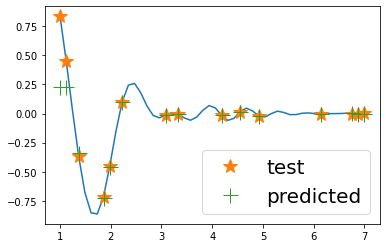

In [256]:
plt.plot(X, y, "-")
plt.plot( X_test, y_test,  "*",ms=15,label='test')
plt.plot( X_test, y_pred,  "+",ms=15,label='predicted')
plt.legend(fontsize=20)

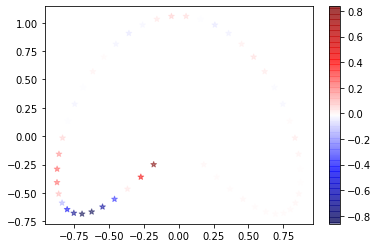

In [257]:
fig, ax = plt.subplots()
regressor.kpca_ncmps = 2
two_dim = regressor.kpca(X)
formation = ax.scatter(two_dim[:,0],two_dim[:,1],marker="*", c=y,vmin=np.min(y), vmax=np.max(y), alpha=0.5, cmap='seismic')
cbar = fig.colorbar(formation, ax=ax)